## *PhotoDissociation Region Toolbox Notebooks*
-------------------------------------------------------------

# Example 1: Working With Measurements

This Example shows how to bring your spectral line and far-infrared (FIR) data into the PDR Toolbox.  Your data can be single pixel values or spatial maps (FITS files). 

In [8]:
# First import the relevant modules.
from pdrtpy.measurement import Measurement
from pdrtpy.modelset import ModelSet
import pdrtpy.pdrutils as utils
from astropy.nddata import StdDevUncertainty
import astropy.units as u
import numpy as np

## Measurements
To use PDR Toolbox, you need to create [`Measurements`](https://pdrtpy.readthedocs.io/en/latest/pdrtpy.measurement.html) from your observations. A `Measurement` consists of a value and an error.  These can be single-valued or an array of values.  In the typical case of an image, the `Measurement` is a representation of a FITS file with two Header Data Units (HDUs), the first HDU is the spatial map of intensity and the 2nd HDU is the spatial map of the errors.  It is based on [astropy's CCDData](https://docs.astropy.org/en/stable/api/astropy.nddata.CCDData.html). Typical sub-millimeter maps we get from telescopes don't have the error plane, but PDRT makes it easy for you to create one if you know the magnitude of the error. Your FITS images can be in intensity units (equivalent to erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$) or can be in K km/s.  PDRT will do appropriate conversion as necessary when it uses your images (original `Measurement` remains unchanged).

### Measurement Identifiers 
When you create a `Measurement` you have to say what it is a measurement of, i.e., what spectral line it is.  This is done using the string identifier.  The identifier (ID) should be one of the lines supported by the PDR Toolbox [`ModelSets`](https://pdrtpy.readthedocs.io/en/latest/pdrtpy.modelset.html).   Here we show the list of lines supported by the Wolfire/Kaufman 2020 constant density models; the *ID* column shows the corresponding identifiers.  See the `ModelSet` example notebook for more about models and what's available.

In [9]:
ModelSet("wk2020",z=1).supported_intensities.show_in_notebook()

idx,title,intensity label
,null,
0,[C I] 609 $\mu$m,CI_609
1,[C II] 158 $\mu$m,CII_158
2,[O I] 63 $\mu$m,OI_63
3,[O I] 145 $\mu$m,OI_145
4,CO(J=1-0),CO_10
5,CO(J=2-1),CO_21
6,CO(J=3-2),CO_32
7,CO(J=4-3),CO_43
8,CO(J=5-4),CO_54


## 1. Creating a Measurement based on a single value

Suppose you have single-beam observations of [OI] 145 $\mu$m, [CI] 609 $\mu$m, CO(J=2-1), and [CII] 158 $\mu$m lines. You create `Measurements` for these using the constructor giving it the value, error, line identifier string, and units.  The value and the error of any `Measurement` must be in the same units.  You can mix units in different `Measurements`; note we use ${\rm K~km~s^{-1}}$ for the CO observation below.   The PDR Toolbox fitting tools will convert all `Measurements` to a common unit before doing any fit. You can also add optional beam size (bmaj,bmin,bpa), however the tools requires all `Measurements` have the same beam size before calculations can be performed.  (If you don't provide beam parameters for any of your `Measurements`, the Toolbox will assume they are all the same).

In [10]:
myunit = "erg s-1 cm-2 sr-1"
m1 = Measurement(data=30.,uncertainty = StdDevUncertainty(5.0),identifier="OI_145",unit=myunit)
m2 = Measurement(data=10.,uncertainty = StdDevUncertainty(2.0),identifier="CI_609",unit=myunit)
m3 = Measurement(data=51.,uncertainty = StdDevUncertainty(6.0),identifier="CO_21",unit="K km/s",
                bmaj=10*u.arcsec,bmin=6*u.arcsec,bpa=-12.3*u.degree)
m4 = Measurement(data=100.,uncertainty = StdDevUncertainty(10.),identifier="CII_158",unit=myunit,
                 bmaj=20*u.arcsec,bmin=20*u.arcsec,bpa=0*u.degree)
print(m1)
# You can convert any Measurement to equivalent units 
w = utils.to("W m^-2 sr^-1",m1)
print(w)
# Print the beam parameters of the CO 
print(f'CO(2-1) beam is {u.Quantity(m3.header["BMAJ"],"deg").to("arcmin").value:.3g} x {u.Quantity(m3.header["BMIN"],"deg").to("arcmin"):.3g}')

30.0 +/- 5.0 erg / (cm2 s sr)
0.03 +/- 0.005 W / (m2 sr)
CO(2-1) beam is 0.167 x 0.1 arcmin


## 2. Creating an array of Measurements from a Table
Instantiation of many Measurements can be done quickly by listing them 
in an external table and reading the table with the `Measurement.from_table` method.
Tables can be in any [astropy recognized format](https://docs.astropy.org/en/stable/io/unified.html#built-in-table-readers-writers).  Required columns are *identifier, data, uncertainty* with optional columns *bmaj, bmin, bpa* following the inputs to the `Measurement` constructor.    Based the unit in the table header, the *uncertainty* will be interpreted as absolute or as a percentage of the *data*.  Included with these notebooks are two example table in IPAC format: `measurement_example1.tab` has *uncertainty* as percent and  `measurement_example2.tab` has beam parameters.

`Measurement.from_table` can return either a single `Measurement` where the data array contains all rows of the table, or Python list of `Measurements` with one Measurement per table row.  This is controlled with the keyword `array`. 

In [11]:
# Read in a table where all rows are put into one Measurement.
a = Measurement.from_table("../data/measurement_example1.tab",array=False)
print("Single Measurement with list of values.")
print(type(a))
print(f"{a:3.5f}\n")

# Read in a table where each row is put into its own Measurement and the list is returned
a2 = Measurement.from_table("../data/measurement_example2.tab",array=True)
print("List of Measurements with single values.")
print(type(a2))
for m in a2:
    print(f'{m.id} {m:3.3e}')

Single Measurement with list of values.
<class 'pdrtpy.measurement.Measurement'>
[0.00109 0.00121 0.00082 0.00094 0.00112 0.00148 0.00151 0.00089 0.00105
 0.00118 0.00146 0.00193 0.00179] +/- [0.00022 0.00024 0.00016 0.00019 0.00022 0.00030 0.00030 0.00018 0.00021
 0.00024 0.00029 0.00039 0.00036] 

List of Measurements with single values.
<class 'list'>
CO_2-1 2.000e+05 +/- 1.234e+02 Jy
CO_3-2 3.000e+05 +/- 4.321e+02 Jy
CO_4-3 4.000e+05 +/- 1.000e+03 Jy
CII_158 5.000e+05 +/- 2.000e+03 Jy
H200S4 6.000e+05 +/- 8.000e+03 Jy
FIR 7.000e+05 +/- 1.800e+03 Jy
H200S6 8.000e+05 +/- 2.900e+03 Jy
H200S7 9.000e+05 +/- 3.333e+03 Jy


## 3. Creating Measurements from a FITS images

Typical sub-millimeter maps we get from telescopes don't have the error plane, but PDRT makes it easy for you to create one if you know the magnitude of the error or if you have a separate error map. Your FITS images can be in intensity units (equivalent to erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$) or can be in K km s$^{-1}$.  PDRT will do appropriate conversion as necessary when it reads in your images.   Here is an example using the N22 data from [Jameson et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...853..111J/abstract). These data consist of separate flux and error maps for [OI] 145 $\mu$m and [CII] 158 $\mu$m,  and a flux map of the total far-infrared emission (FIR) which has a 10% error.  The static method `Measurement.make_measurement` will put the flux and error together in a single image with 2 HDUs and write that FITS file to disk.  You then read the image back in via the `read` method.

*Note:* This example locates in the test data distributed with these `pdrtpy` using a shortcut `utils.get_testdata`.  In more typical operation, you would simply provide the full-qualified pathnames to your FITS data files. 

In [12]:
# Get the input filenames of the FITS files in the testdata directory
# These are maps from Jameson et al 2018.
print("Test FITS files are in: %s"%utils.testdata_dir())
cii_flux = utils.get_testdata("n22_cii_flux.fits")  # [C II] flux
cii_err = utils.get_testdata("n22_cii_error.fits")  # [C II] error
oi_flux = utils.get_testdata("n22_oi_flux.fits")    # [O I] flux 
oi_err = utils.get_testdata("n22_oi_error.fits")    # [O I] error
FIR_flux = utils.get_testdata("n22_FIR.fits")       # FIR flux

# Output file names
cii_combined = "n22_cii_flux_error.fits"
oi_combined = "n22_oi_flux_error.fits"
FIR_combined = "n22_FIR_flux_error.fits"

# create the Measurements and write out the FITS files.
# Set overwrite=True to allow multiple runs of this notebook.
Measurement.make_measurement(cii_flux, cii_err, cii_combined,overwrite=True)
Measurement.make_measurement(oi_flux, oi_err, oi_combined,overwrite=True)
# Assign a 10% error in FIR flux
Measurement.make_measurement(FIR_flux, error='10%', outfile=FIR_combined,overwrite=True)

# Read in the FITS files to Measurements
cii_meas = Measurement.read(cii_combined, identifier="CII_158")
FIR_meas = Measurement.read(FIR_combined, identifier="FIR")
oi_meas = Measurement.read(oi_combined, identifier="OI_63")

print("World Coordinate System:\n",oi_meas.wcs)
print("\n[OI] max %.2E min %.2E  %s"%(np.nanmax(oi_meas.data), np.nanmin(oi_meas.data),oi_meas.unit))

Test FITS files are in: /home/mpound/src/pdrtpy/pdrtpy/testdata/
World Coordinate System:
 WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 12.10878606  -73.33488267  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00079167  0.00079167  
NAXIS : 81  139

[OI] max 2.48E-07 min 3.33E-09  W / (m2 sr)


## The more you have in the FITS header the less you have to specify

Here we read in the CO(J=1-0) integrated intensity map that has the units, error, and beam parameters specified by the FITS keywords BUNIT, RMS, BMAJ, BMIN, BPA respectively.  So they don't need to be supplied with the Measurement constructor. These are old Bell Labs 7-m data of the Draco High Latitude Cloud (MBM 41-44).


In [13]:
outfile="draco_CO_measurement.fits"
infile=utils.get_testdata("draco.ico.fits")
Measurement.make_measurement(infile,error='rms',outfile=outfile,overwrite=True)
ico = Measurement.read(outfile,identifier="CO_10")
# RMS and beam size are determined from the FITS header
print(f"The RMS of this map is {ico.error[0][0]:0.1f} {ico.unit}")
print(f'The CO(1-0) beam is {u.Quantity(ico.header["BMAJ"],"deg").to("arcmin").value:.3g} x {u.Quantity(ico.header["BMIN"],"deg").to("arcmin"):.3g}')

Found RMS in header: 3.00E-01 (1, 163, 138)
The RMS of this map is 0.3 K km / s
The CO(1-0) beam is 1.67 x 1.67 arcmin


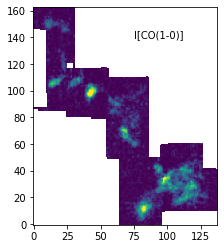

In [14]:
import matplotlib.pyplot as plt
plt.imshow(ico,origin='lower',vmin=-0.1,vmax=12)
t=plt.text(75,140,r"I[CO(1-0)]")